<a href="https://colab.research.google.com/github/clondonop/Nutricheck/blob/master/Final_O_R_Modelo_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import re
import seaborn as sns
import math 

from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Inteligencia Artificial/Dataset2.zip"

In [ ]:
!unzip "/content/drive/MyDrive/Universidad/Semestre 7 y 8/Semestre 8/Inteligencia Artificial/Dataset2.zip"

## Crear conjunto entrenamiento y prueba


In [37]:
PATH = '/content/DATASET'

In [38]:
fnames_train = np.array([f'{PATH}/TRAIN/{f}' for f in (os.listdir(f'{PATH}/TRAIN/O'))])
fnames_train=np.append(fnames_train,[f'{PATH}/TRAIN/{f}' for f in (os.listdir(f'{PATH}/TRAIN/R'))])
labels_train = np.array([(0 if 'O_' in fname else 1) for fname in fnames_train])

In [39]:
fnames_train

array(['/content/DATASET/TRAIN/O_7032.jpg',
       '/content/DATASET/TRAIN/O_10737.jpg',
       '/content/DATASET/TRAIN/O_6257.jpg', ...,
       '/content/DATASET/TRAIN/R_3124.jpg',
       '/content/DATASET/TRAIN/R_2464.jpg',
       '/content/DATASET/TRAIN/R_7395.jpg'], dtype='<U34')

In [40]:
np.unique(labels_train,return_counts=True)

(array([0, 1]), array([12565,  9999]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Organico y Reciclable')

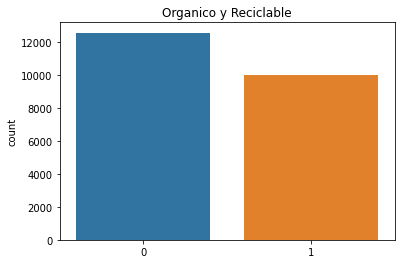

In [41]:
sns.countplot(labels_train)
plt.title('Organico y Reciclable')

In [42]:
fnames_test = np.array([f'{PATH}/TEST/{f}' for f in (os.listdir(f'{PATH}/TEST/O'))])
fnames_test=np.append(fnames_test,[f'{PATH}/TST/{f}' for f in (os.listdir(f'{PATH}/TEST/R'))])
labels_test = np.array([(0 if 'O_' in fname else 1) for fname in fnames_test])

In [43]:
np.unique(labels_test,return_counts=True)

(array([0, 1]), array([1401, 1112]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Organico y Reciclable')

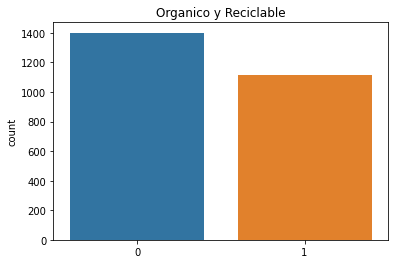

In [44]:
sns.countplot(labels_test)
plt.title('Organico y Reciclable')

In [45]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [83]:
train_generator = train_data_gen.flow_from_directory(
    directory=PATH+'/TRAIN',
    target_size=((256,256)),
    class_mode='binary',
    batch_size=64,
    seed=25070726,
    subset = 'training')

Found 18052 images belonging to 2 classes.


In [85]:
val_generator = val_data_gen.flow_from_directory(
    directory = PATH+'/TRAIN',
    target_size = (256,256),
    class_mode = 'binary',
    batch_size = 64, 
    seed=25070726,
    subset = 'validation')


Found 4512 images belonging to 2 classes.


In [86]:
test_generator = train_data_gen.flow_from_directory(
    directory=PATH+'/TEST',
    target_size=((256,256)),
    class_mode='binary',
    batch_size=64)

Found 2513 images belonging to 2 classes.


In [49]:
class CollectBatch(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses=[]
    self.batch_accuracy=[]

  def on_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_accuracy.append(logs['acc'])

batch_stats=CollectBatch()

In [87]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

In [103]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Construir un modelo de red neuronal

In [108]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [109]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 30, 30, 128)     

Definir el algoritmo de aprendizaje y las métricas a medir

In [110]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

Entrenar el modelo

In [111]:
history = model.fit(
        train_generator,
        epochs=15,
        callbacks = [batch_stats],
        validation_data=val_generator,
        verbose = 1)

Epoch 1/15
283/283 [==============================] - 316s 1s/step - loss: 0.4626 - acc: 0.8035 - val_loss: 0.4541 - val_acc: 0.7806
Epoch 2/15
283/283 [==============================] - 315s 1s/step - loss: 0.3992 - acc: 0.8310 - val_loss: 0.4250 - val_acc: 0.7945
Epoch 3/15
283/283 [==============================] - 314s 1s/step - loss: 0.3702 - acc: 0.8437 - val_loss: 0.4250 - val_acc: 0.8036
Epoch 4/15
283/283 [==============================] - 324s 1s/step - loss: 0.3568 - acc: 0.8499 - val_loss: 0.3820 - val_acc: 0.8280
Epoch 5/15
283/283 [==============================] - 316s 1s/step - loss: 0.3517 - acc: 0.8545 - val_loss: 0.3924 - val_acc: 0.8526
Epoch 6/15
283/283 [==============================] - 320s 1s/step - loss: 0.3458 - acc: 0.8583 - val_loss: 0.3872 - val_acc: 0.8203
Epoch 7/15
283/283 [==============================] - 314s 1s/step - loss: 0.3359 - acc: 0.8623 - val_loss: 0.3695 - val_acc: 0.8378
Epoch 8/15
283/283 [==============================] - 314s 1s/step - 

In [113]:
model.save("/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloNuevoSP.h5")

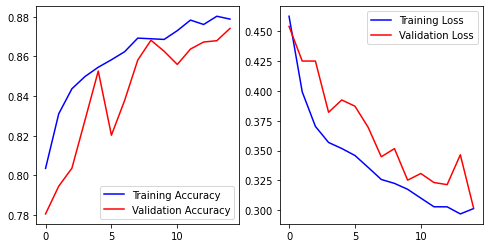

In [115]:
acc=history.history['acc']
val_acc=history.history['val_acc']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [116]:
test_loss, test_acc=model.evaluate(test_generator)

40/40 [==============================] - 38s 956ms/step - loss: 0.2684 - acc: 0.8977


In [160]:
Y_pred = model.predict(test_generator)

Classification Report
              precision    recall  f1-score   support

           O       0.55      0.51      0.53      1401
           R       0.44      0.48      0.46      1112

    accuracy                           0.50      2513
   macro avg       0.49      0.49      0.49      2513
weighted avg       0.50      0.50      0.50      2513



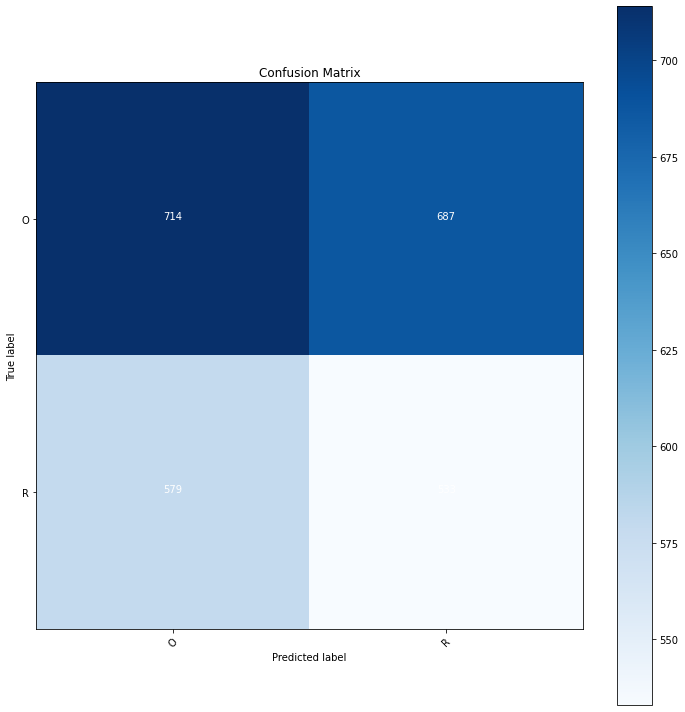

In [130]:
y_pred =[(0 if element<0.1 else 1) for element in Y_pred]
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Con otros modelos

In [125]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import SGD

###VGG16

In [ ]:
modelVG16 = VGG16(include_top=False, input_shape=(256, 256, 3))
for layer in modelVG16.layers:
  layer.trainable = False

x= GlobalAveragePooling2D()(modelVG16.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

modelVG16 = Model(inputs=modelVG16.inputs, outputs=x)

opt = SGD(lr=0.001, momentum=0.9)
modelVG16.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])


58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
historyVG16 = modelVG16.fit(
        train_generator,
        epochs=25,
        callbacks = [batch_stats],
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // 64)

Epoch 1/25
90/90 [==============================] - 78s 856ms/step - loss: 2.2304 - acc: 0.2030 - val_loss: 2.1474 - val_acc: 0.2854
Epoch 2/25
90/90 [==============================] - ETA: 0s - loss: 2.0989 - acc: 0.3061

In [ ]:
modelVG16.save("/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloVGG16.h5")

In [126]:
VG16_model= tf.keras.models.load_model('/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloVGG16.h5',)

In [127]:
test_lossVG16, test_accVG16=VG16_model.evaluate(test_generator)

40/40 [==============================] - 71s 1s/step - loss: 0.1335 - acc: 0.9467


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


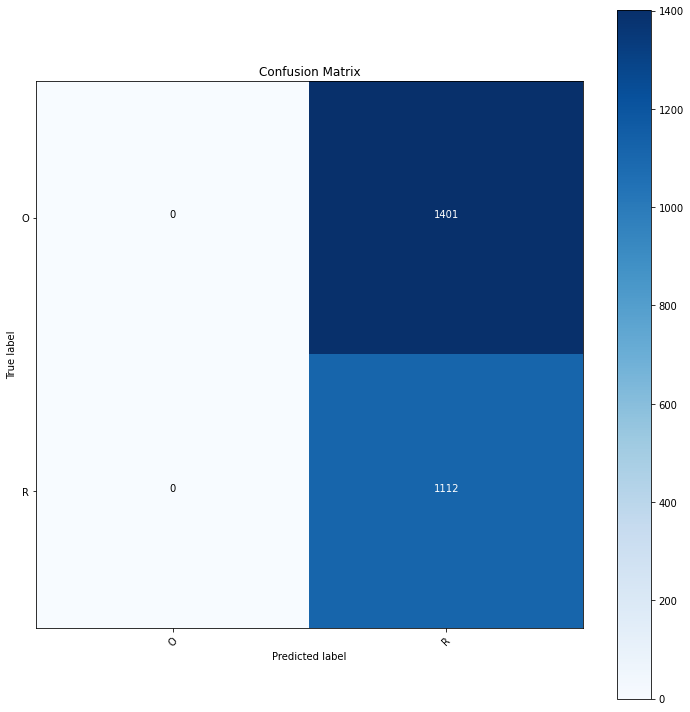

In [128]:
Y_pred = VG16_model.predict(test_generator)


In [ ]:
y_pred =[math.ceil(element) for element in Y_pred]
print(y_pred)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

###RestNet50

In [ ]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256,3 ))

x = base_model.output
# Flatten layer
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(1, activation='sigmoid')(x)
modelRN50 = Model(inputs = base_model.input, outputs = x)
modelRN50.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
historyRN50 = modelRN50.fit(
        train_generator,
        epochs=12,
        callbacks = [batch_stats],
        validation_data=val_generator,
        verbose = 1)

Epoch 1/12
101/283 [=========>....................] - ETA: 5:03 - loss: 0.7780 - acc: 0.7455

In [ ]:
modelRN50.save("/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloRN50.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [131]:
RN50_model= tf.keras.models.load_model('/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloRN50.h5',)

In [132]:
test_lossRN50, test_accRN50=RN50_model.evaluate(test_generator)

40/40 [==============================] - 49s 1s/step - loss: 0.3477 - acc: 0.8575


In [158]:
Y_predRN50 = RN50_model.predict(test_generator)

[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


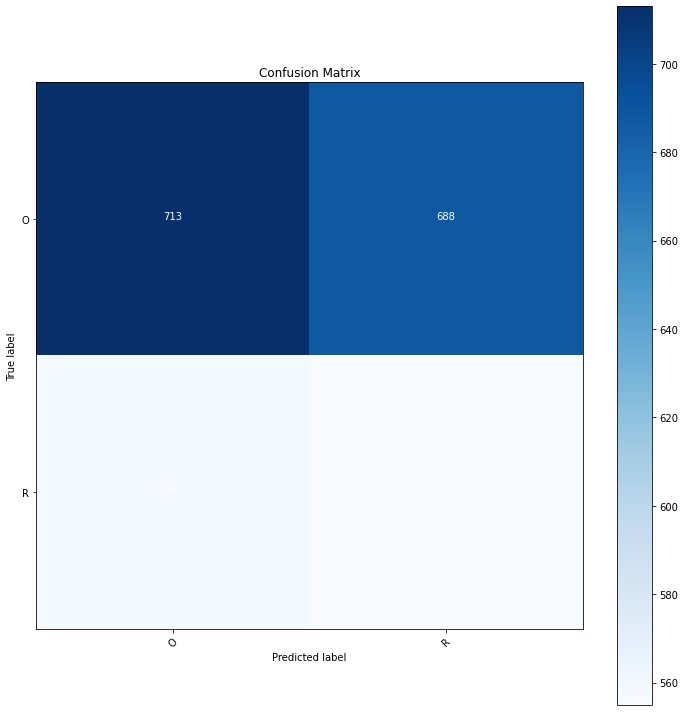

In [159]:
y_predRN50 =[(0 if element<0.000001 else 1) for element in Y_predRN50]
print(y_pred)
target_names = classes

# Confusion Matrix
cmRN50 = confusion_matrix(test_generator.classes, y_predRN50)

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_predRN50, target_names=target_names))

##Comparacion modelos CNN


In [139]:
print("Propio->","Loss:",test_loss,"Acc:", test_acc)
print("VGG16->","Loss:",test_lossVG16,"Acc:", test_accVG16)
print("RN50->","Loss:",test_lossRN50,"Acc:", test_accRN50)


Propio-> Loss: 0.26836442947387695 Acc: 0.8977317810058594
VGG16-> Loss: 0.13345398008823395 Acc: 0.9466772675514221
RN50-> Loss: 0.34772565960884094 Acc: 0.8575407862663269



# Transfer learning con el modelo


In [141]:
ml_model= tf.keras.models.load_model('/content/drive/MyDrive/Inteligencia Artificial/Trabajo 4/ModeloNuevoSP.h5',)
ml_model.pop()
ml_model.add(Flatten())
ml_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 30, 30, 128)     

In [143]:
Y_pred = ml_model.predict(test_generator)

In [146]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC #SVM 
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier #Arbol
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB #NAive Bayes
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [152]:
scoring = ['precision_macro', 'recall_macro','f1_macro']
acurracy=[]
scores =[]
names=['KNN','SVM Lineal','Árbol de decisión','Naive Bayes','MLP']
classifiers = [
    KNeighborsClassifier(n_neighbors=4, metric='euclidean'), #KNN
    SVC(kernel="linear", C=0.025), #SVM lineal
    DecisionTreeClassifier(max_depth=3), #Arbol
    GaussianNB()] #Bayes
    #MLPClassifier(solver='lbfgs', hidden_layer_sizes=6,alpha=1e-5,random_state=1,max_iter=10000) ]#MLP
for clf in classifiers:
  acurracy.append(cross_val_score(clf, Y_pred, test_generator.classes, cv=10))
  scores.append(cross_validate(clf, Y_pred,test_generator.classes, scoring=scoring, cv=10))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

In [154]:
data_a=[]
data_s=[]
names=['KNN','SVM Lineal','Árbol de decisión','Naive Bayes']
for i in acurracy:
  data_a.append(i.mean())
for j in scores:
  data_s.append(j['test_recall_macro'].mean())
resultados = pd.DataFrame(data=[data_a,data_s],index=["Acurracy","Scores"],columns=names)
resultados

,KNN,SVM Lineal,Árbol de decisión,Naive Bayes
Acurracy,0.524472,0.557502,0.557095,0.540783
Scores,0.495329,0.500000,0.506291,0.499183


In [ ]:
scores =[]
predicted_targets = np.array([])
actual_targets = np.array([])
errores = []
names=['KNN','SVM Lineal','Árbol de decisión','Naive Bayes','MLP']
cont = 1
classifiers = [
  KNeighborsClassifier(n_neighbors=4, metric='euclidean'), #KNN
  SVC(kernel="linear", C=0.025), #SVM lineal
  DecisionTreeClassifier(max_depth=3), #Arbol
  GaussianNB(), #Bayes
  MLPClassifier(solver='lbfgs', hidden_layer_sizes=8,alpha=1e-5,random_state=1,max_iter=10000) ]#MLP
  for i,clf in enumerate(classifiers) :
    clf.fit(Y_pred,test_generator.classes)
    scores.append(clf.score(Y_pred,test_generator.classes))
    ml_pred = clf.predict(Y_pred)
    predicted_targets = np.append(predicted_targets, ml_pred)
    actual_targets = np.append(actual_targets, test_generator.classes)

    for j in range(0,len(ml_pred)):
      if( ml_pred[j] != test_generator.classes[j]):
        errores.append([names[i],j,cont,ml_pred[j],test_generator.classes[j]])
    
    print(names[i])
    cm = confusion_matrix(test_generator.classes, ml_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm,interpolation='nearest',cmap=plt.get_cmap('Blues'))
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
  
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i,j],'d'),horizontalalignment="center")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')
    plt.show()
    cont+=1



  pd.crosstab(test_generator.classes, ml_pred, rownames=['True'], colnames=['Predicted'], margins=True)

rf = pd.DataFrame(data=errores,columns=["Modelo","Caso","Prediccion","Real"])
rf